<h1>
  <hr style="border:none; height:3px;">
  <center>Data Cleaning for Semi-Supervised Learning</center>
  <hr style="border:none; height:3px;">
</h1>

All the preprocessing steps outlined below will be explained in the dedicated Jupyter notebook that focuses on investigating these processes. In this document, the steps are directly implemented to prepare a cleaned CSV database for subsequent semi-supervised learning.

# Set up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# numpy arrays are used to .
import numpy as np

# pandas is used to manipulate tabular data.
import pandas as pd

# statsmodels provides classes and functions for the estimation of many different statistical models.
import statsmodels.api as sm

# itertools implements a number of iterator building blocks for efficient looping.
import itertools

# time provides various time-related functions
import time

# Matplotlib is used to plot graphs
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## For PCA part
#################
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
!pip install chart_studio
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go


Defaulting to user installation because normal site-packages is not writeable


# Read the database

In [2]:
# Define the column names
column_names = [
    "Carbon concentration (weight%)", "Silicon concentration (weight%)", 
    "Manganese concentration (weight%)", "Sulphur concentration (weight%)", 
    "Phosphorus concentration (weight%)", "Nickel concentration (weight%)", 
    "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", 
    "Vanadium concentration (weight%)", "Copper concentration (weight%)", 
    "Cobalt concentration (weight%)", "Tungsten concentration (weight%)", 
    "Oxygen concentration (ppm)", "Titanium concentration (ppm)", 
    "Nitrogen concentration (ppm)", "Aluminium concentration (ppm)", 
    "Boron concentration (ppm)", "Niobium concentration (ppm)", 
    "Tin concentration (ppm)", "Arsenic concentration (ppm)", 
    "Antimony concentration (ppm)", "Current (A)", "Voltage (V)", 
    "AC or DC", "Electrode positive or negative", "Heat input (kJmm-1)", 
    "Interpass temperature (°C)", "Type of weld", "Post weld heat treatment temperature (°C)", 
    "Post weld heat treatment time (hours)", "Yield strength (MPa)", 
    "Ultimate tensile strength (MPa)", "Elongation (%)", 
    "Reduction of Area (%)", "Charpy temperature (°C)", 
    "Charpy impact toughness (J)", "Hardness (kgmm-2)", "50 % FATT", 
    "Primary ferrite in microstructure (%)", "Ferrite with second phase (%)", 
    "Acicular ferrite (%)", "Martensite (%)", "Ferrite with carbide aggregate (%)", 
    "Weld ID"
]

file_path = 'welddb/welddb.data'
welddb = pd.read_csv(file_path, delim_whitespace=True, header=None, names=column_names)

print(welddb.shape)

(1652, 44)


C:\Users\12264\AppData\Local\Temp\ipykernel_20820\2021365927.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  welddb = pd.read_csv(file_path, delim_whitespace=True, header=None, names=column_names)


# Clean the database

1. **Handle Missing Values**: 
   - Replace occurrences of `'N'` with `NaN` (using NumPy) to mark them as missing data.

2. **Fix Object-Type Columns with '<' Symbols**:
   - Remove the `'<'` symbol (which indicates a very small concentration or percentage) so that these columns can be converted to numeric types. 

3. **Extract Numeric Values from Nitrogen concentration (ppm)**:
   - `'67tot33res'` should be simplified to `67.0`.

4. **Drop the 'Weld ID' Column**:
   - The **'Weld ID'** column contains names for welds, indicating some reference sources.


In [3]:
welddb.replace({'N': np.nan}, regex=True, inplace=True)
welddb = welddb.apply(pd.to_numeric, errors='ignore')

welddb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1648 non-null   object 
 4   Phosphorus concentration (weight%)         1642 non-null   float64
 5   Nickel concentration (weight%)             697 non-null    float64
 6   Chromium concentration (weight%)           784 non-null    float64
 7   Molybdenum concentration (weight%)         793 non-null    object 
 8   Vanadium concentration (weight%)           928 non-null    object 
 9   Copper concentration (weight%)             578 non-null    object 
 10  Cobalt concentration (we

C:\Users\12264\AppData\Local\Temp\ipykernel_20820\3809596426.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  welddb = welddb.apply(pd.to_numeric, errors='ignore')


In [4]:
# Count occurrences of symbol '<' in the object-type columns and check them
object_columns = welddb.select_dtypes(include=['object'])
symbol_counts = {'<': 0}

for column in object_columns.columns:
    # Count occurrences of '<' in each column
    less_than_count = object_columns[column].str.contains('<').sum()
    
    symbol_counts['<'] += less_than_count
    
    print(f"Column: {column} -> '<' count: {less_than_count}")

print(f"Total '<' count: {symbol_counts['<']}")

Column: Sulphur concentration (weight%) -> '<' count: 7
Column: Molybdenum concentration (weight%) -> '<' count: 2
Column: Vanadium concentration (weight%) -> '<' count: 308
Column: Copper concentration (weight%) -> '<' count: 14
Column: Cobalt concentration (weight%) -> '<' count: 21
Column: Tungsten concentration (weight%) -> '<' count: 12
Column: Titanium concentration (ppm) -> '<' count: 70
Column: Nitrogen concentration (ppm) -> '<' count: 0
Column: Aluminium concentration (ppm) -> '<' count: 403
Column: Boron concentration (ppm) -> '<' count: 419
Column: Niobium concentration (ppm) -> '<' count: 299
Column: Tin concentration (ppm) -> '<' count: 5
Column: Arsenic concentration (ppm) -> '<' count: 8
Column: Antimony concentration (ppm) -> '<' count: 6
Column: AC or DC -> '<' count: 0
Column: Electrode positive or negative -> '<' count: 0
Column: Interpass temperature (°C) -> '<' count: 0
Column: Type of weld -> '<' count: 0
Column: Hardness (kgmm-2) -> '<' count: 0
Column: Primary 

In [5]:
welddb.replace({r'<': '', }, regex=True, inplace=True)
welddb = welddb.apply(pd.to_numeric, errors='ignore')

welddb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1648 non-null   float64
 4   Phosphorus concentration (weight%)         1642 non-null   float64
 5   Nickel concentration (weight%)             697 non-null    float64
 6   Chromium concentration (weight%)           784 non-null    float64
 7   Molybdenum concentration (weight%)         793 non-null    float64
 8   Vanadium concentration (weight%)           928 non-null    float64
 9   Copper concentration (weight%)             578 non-null    float64
 10  Cobalt concentration (we

C:\Users\12264\AppData\Local\Temp\ipykernel_20820\2246164395.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  welddb = welddb.apply(pd.to_numeric, errors='ignore')


In [6]:
object_columns = welddb.select_dtypes(include=['object'])

# Apply value_counts() for each column and print the result
for column in object_columns.columns:
    print(f"Value counts for column: {column}")
    print(welddb[column].value_counts())
    print("\n")

Value counts for column: Nitrogen concentration (ppm)
Nitrogen concentration (ppm)
80     38
77     36
84     31
81     30
75     29
       ..
122     1
121     1
116     1
540     1
394     1
Name: count, Length: 161, dtype: int64


Value counts for column: AC or DC
AC or DC
DC    1395
AC      42
Name: count, dtype: int64


Value counts for column: Electrode positive or negative
Electrode positive or negative
+    1451
0      38
-       7
Name: count, dtype: int64


Value counts for column: Interpass temperature (°C)
Interpass temperature (°C)
200        1064
250         171
300         118
150         102
175          52
100          40
150-200      38
210          20
177          16
107           8
125           6
225           5
140           4
20            4
240           4
Name: count, dtype: int64


Value counts for column: Type of weld
Type of weld
MMA     1140
SA       261
FCA       87
TSA       87
ShMA      40
SAA        4
GTAA       4
GMAA       4
Name: count, dtype: int64


In [7]:
# Find the non-numeric entries in 'Nitrogen concentration (ppm)'
welddb['Nitrogen concentration (ppm)_numeric'] = pd.to_numeric(welddb['Nitrogen concentration (ppm)'], errors='coerce')

# Identify rows where the conversion resulted in NaN (indicating non-numeric values)
problematic_entries = welddb[welddb['Nitrogen concentration (ppm)_numeric'].isna() & ~welddb['Nitrogen concentration (ppm)'].isna()]

print(problematic_entries[['Nitrogen concentration (ppm)']])
print(problematic_entries[['Nitrogen concentration (ppm)']].shape)


    Nitrogen concentration (ppm)
274                   67tot33res
275                   67tot33res
276                   67tot33res
277                   67tot33res
278                   67tot33res
279                   67tot33res
280                   67tot33res
281                   66totndres
282                   66totndres
283                   66totndres
284                   66totndres
285                   66totndres
286                   66totndres
287                   66totndres
288                   66totndres
289                   66totndres
290                   66totndres
291                   66totndres
292                   61tot34res
293                   61tot34res
294                   61tot34res
295                   61tot34res
296                   61tot34res
297                   61tot34res
298                   61tot34res
299                   54totndres
300                   54totndres
301                   54totndres
302                   54totndres
303       

In [8]:
# Extract the first number from entries like '67tot33res'
welddb['Nitrogen concentration (ppm)'] = welddb['Nitrogen concentration (ppm)'].str.extract(r'(\d+)', expand=False)

# Convert the column to numeric type
welddb['Nitrogen concentration (ppm)'] = pd.to_numeric(welddb['Nitrogen concentration (ppm)'], errors='coerce')

In [9]:
welddb = welddb.drop(columns=['Nitrogen concentration (ppm)_numeric'])

In [10]:
welddb = welddb.drop(columns=['Weld ID'])

5. **Recalculate Hardness (kgmm-2)**:

    In this column, we have two types of hardness values:

    1. **Numerical values**: These are already standardized, such as `257`, `153`, etc.
    2. **Mixed values**: These values are formatted as `xHVy` (e.g., `150Hv30`), where `x` is the hardness value and `y` is the load in kgf used during the test.

    We need to standardize all the values in this column so that they are comparable, assuming a standard load of **10 kgf**.

    We will use the following formula to standardize values to a common load (e.g., 10 kgf):



    $$
    Hv_{\text{standard}} = Hv_{\text{measured}} \times \left( \frac{L_{\text{standard}}}{L_{\text{measured}}} \right)^n
    $$

    Where:
    - $ Hv_{\text{standard}} $ is the standardized hardness value.
    - $ Hv_{\text{measured}} $ is the hardness value measured at a specific load.
    - $  L_{\text{standard}} $ is the standard load we will choose (in this case, **10 kgf**).
    - $  L_{\text{measured}} $ is the load used during the measurement (extracted from the notation `xHVy`).
    - $  n  $ is an empirical constant, typically around **0.2** for metals.

In [11]:
welddb['Hardness (kgmm-2)'].unique()

array([nan, '257', '227', '224', '226', '234', '217', '213', '209', '259',
       '239', '223', '230', '252', '241', '231', '229', '180', '174',
       '220', '184', '193', '189', '181', '183', '194', '216', '191',
       '164', '154', '265', '225', '196', '202', '197', '172',
       '158(Hv30)', '155(Hv30)', '153(Hv30)', '161(Hv30)', '168(Hv30)',
       '203(Hv30)', '157(Hv30)', '174(Hv30)', '144(Hv30)', '143(Hv30)',
       '154(Hv30)', '170(Hv30)', '459Hv10', '405Hv10', '451Hv10',
       '432Hv10', '264Hv10', '241Hv10', '251Hv10', '225Hv10', '233Hv10',
       '208Hv10', '373Hv10', '224Hv10', '210Hv10', '212Hv10', '202Hv10',
       '204Hv10', '201Hv10', '398Hv10', '249Hv10', '226Hv10', '234Hv10',
       '219Hv10', '467Hv10', '277Hv10', '254Hv10', '263Hv10', '237Hv10',
       '362Hv10', '291Hv10', '262Hv10', '266Hv10', '253Hv10', '257Hv10',
       '246Hv10', '264Hv5', '269Hv5', '233Hv5', '226Hv5', '222', '205',
       '253', '219', '182', '199', '240', '244', '247', '233', '212'],
    

In [12]:
welddb['Hardness (kgmm-2)'] = welddb['Hardness (kgmm-2)'].str.replace(r"[()]", "", regex=True)
welddb['Hardness (kgmm-2)'].unique()

array([nan, '257', '227', '224', '226', '234', '217', '213', '209', '259',
       '239', '223', '230', '252', '241', '231', '229', '180', '174',
       '220', '184', '193', '189', '181', '183', '194', '216', '191',
       '164', '154', '265', '225', '196', '202', '197', '172', '158Hv30',
       '155Hv30', '153Hv30', '161Hv30', '168Hv30', '203Hv30', '157Hv30',
       '174Hv30', '144Hv30', '143Hv30', '154Hv30', '170Hv30', '459Hv10',
       '405Hv10', '451Hv10', '432Hv10', '264Hv10', '241Hv10', '251Hv10',
       '225Hv10', '233Hv10', '208Hv10', '373Hv10', '224Hv10', '210Hv10',
       '212Hv10', '202Hv10', '204Hv10', '201Hv10', '398Hv10', '249Hv10',
       '226Hv10', '234Hv10', '219Hv10', '467Hv10', '277Hv10', '254Hv10',
       '263Hv10', '237Hv10', '362Hv10', '291Hv10', '262Hv10', '266Hv10',
       '253Hv10', '257Hv10', '246Hv10', '264Hv5', '269Hv5', '233Hv5',
       '226Hv5', '222', '205', '253', '219', '182', '199', '240', '244',
       '247', '233', '212'], dtype=object)

In [13]:
n=0.2
L_standard = 10

def transformer(x):
    try:
        return float(x)
    except:
        if x != np.nan :
            liste=x.split('Hv')
            L_measured = float(liste[1])
            HV_measured = float(liste[0])
            return HV_measured*((L_standard/L_measured)**n)

In [14]:
welddb['Hardness (kgmm-2)'] = welddb['Hardness (kgmm-2)'].apply(transformer)
welddb['Hardness (kgmm-2)'].unique()

array([         nan, 257.        , 227.        , 224.        ,
       226.        , 234.        , 217.        , 213.        ,
       209.        , 259.        , 239.        , 223.        ,
       230.        , 252.        , 241.        , 231.        ,
       229.        , 180.        , 174.        , 220.        ,
       184.        , 193.        , 189.        , 181.        ,
       183.        , 194.        , 216.        , 191.        ,
       164.        , 154.        , 265.        , 225.        ,
       196.        , 202.        , 197.        , 172.        ,
       126.83316676, 124.42494207, 122.81945895, 129.24139144,
       134.86058238, 162.95653704, 126.0304252 , 139.67703175,
       115.59478489, 114.79204333, 123.62220051, 136.4660655 ,
       459.        , 405.        , 451.        , 432.        ,
       264.        , 251.        , 233.        , 208.        ,
       373.        , 210.        , 212.        , 204.        ,
       201.        , 398.        , 249.        , 219.  

In [15]:
welddb['Hardness (kgmm-2)'].dtype

dtype('float64')

In [16]:
welddb['Hardness (kgmm-2)'] = welddb['Hardness (kgmm-2)'].round(2)
welddb['Hardness (kgmm-2)'].unique()

array([   nan, 257.  , 227.  , 224.  , 226.  , 234.  , 217.  , 213.  ,
       209.  , 259.  , 239.  , 223.  , 230.  , 252.  , 241.  , 231.  ,
       229.  , 180.  , 174.  , 220.  , 184.  , 193.  , 189.  , 181.  ,
       183.  , 194.  , 216.  , 191.  , 164.  , 154.  , 265.  , 225.  ,
       196.  , 202.  , 197.  , 172.  , 126.83, 124.42, 122.82, 129.24,
       134.86, 162.96, 126.03, 139.68, 115.59, 114.79, 123.62, 136.47,
       459.  , 405.  , 451.  , 432.  , 264.  , 251.  , 233.  , 208.  ,
       373.  , 210.  , 212.  , 204.  , 201.  , 398.  , 249.  , 219.  ,
       467.  , 277.  , 254.  , 263.  , 237.  , 362.  , 291.  , 262.  ,
       266.  , 253.  , 246.  , 303.26, 309.  , 267.65, 259.61, 222.  ,
       205.  , 182.  , 199.  , 240.  , 244.  , 247.  ])

6. **Replace the range with the mean value for Interpass temperature (°C)**:

In [17]:
# Replace the '150-200' entries with the mean of the range (175)
welddb['Interpass temperature (°C)'] = welddb['Interpass temperature (°C)'].replace('150-200', 175)

# Convert the column to numeric (in case there are any non-numeric entries remaining)
welddb['Interpass temperature (°C)'] = pd.to_numeric(welddb['Interpass temperature (°C)'], errors='coerce')

In [18]:
welddb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1648 non-null   float64
 4   Phosphorus concentration (weight%)         1642 non-null   float64
 5   Nickel concentration (weight%)             697 non-null    float64
 6   Chromium concentration (weight%)           784 non-null    float64
 7   Molybdenum concentration (weight%)         793 non-null    float64
 8   Vanadium concentration (weight%)           928 non-null    float64
 9   Copper concentration (weight%)             578 non-null    float64
 10  Cobalt concentration (we

In [19]:
welddb.describe()

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Reduction of Area (%),Charpy temperature (°C),Charpy impact toughness (J),Hardness (kgmm-2),50 % FATT,Primary ferrite in microstructure (%),Ferrite with second phase (%),Acicular ferrite (%),Martensite (%),Ferrite with carbide aggregate (%)
count,1652.000000,1652.000000,1652.000000,1648.000000,1642.000000,697.000000,784.000000,793.000000,928.000000,578.000000,...,705.000000,879.000000,879.00000,138.000000,31.000000,98.000000,90.000000,90.000000,89.000000,89.000000
mean,0.075521,0.328577,1.202821,0.009529,0.012952,0.415034,2.101273,0.479172,0.097379,0.172163,...,71.799858,-34.606371,87.68942,224.261087,-31.096774,19.173469,25.955556,52.833333,0.337079,0.438202
std,0.023898,0.112455,0.382137,0.011226,0.019627,0.786951,3.026548,0.477404,0.492889,0.322933,...,8.926551,34.738624,50.11670,63.293376,43.644285,10.982672,21.283486,23.483798,3.179994,1.397685
min,0.029000,0.040000,0.270000,0.001000,0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,...,17.000000,-114.000000,3.00000,114.790000,-126.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,0.061750,0.270000,0.940000,0.006000,0.007000,0.000000,0.000000,0.000000,0.000500,0.000000,...,68.000000,-60.000000,38.00000,193.000000,-62.000000,13.000000,9.000000,35.500000,0.000000,0.000000
50%,0.074000,0.320000,1.270000,0.007000,0.010000,0.067000,0.530000,0.340000,0.009500,0.030000,...,75.000000,-40.000000,100.00000,224.000000,-15.000000,19.000000,18.000000,60.000000,0.000000,0.000000
75%,0.086000,0.360000,1.440000,0.010000,0.014000,0.260000,2.300000,1.010000,0.044000,0.180000,...,78.000000,-17.500000,100.00000,241.000000,5.000000,23.750000,38.000000,71.750000,0.000000,0.000000
max,0.180000,1.140000,2.250000,0.140000,0.250000,3.500000,10.200000,1.500000,5.000000,1.630000,...,83.000000,188.000000,270.00000,467.000000,30.000000,48.000000,100.000000,88.000000,30.000000,8.000000


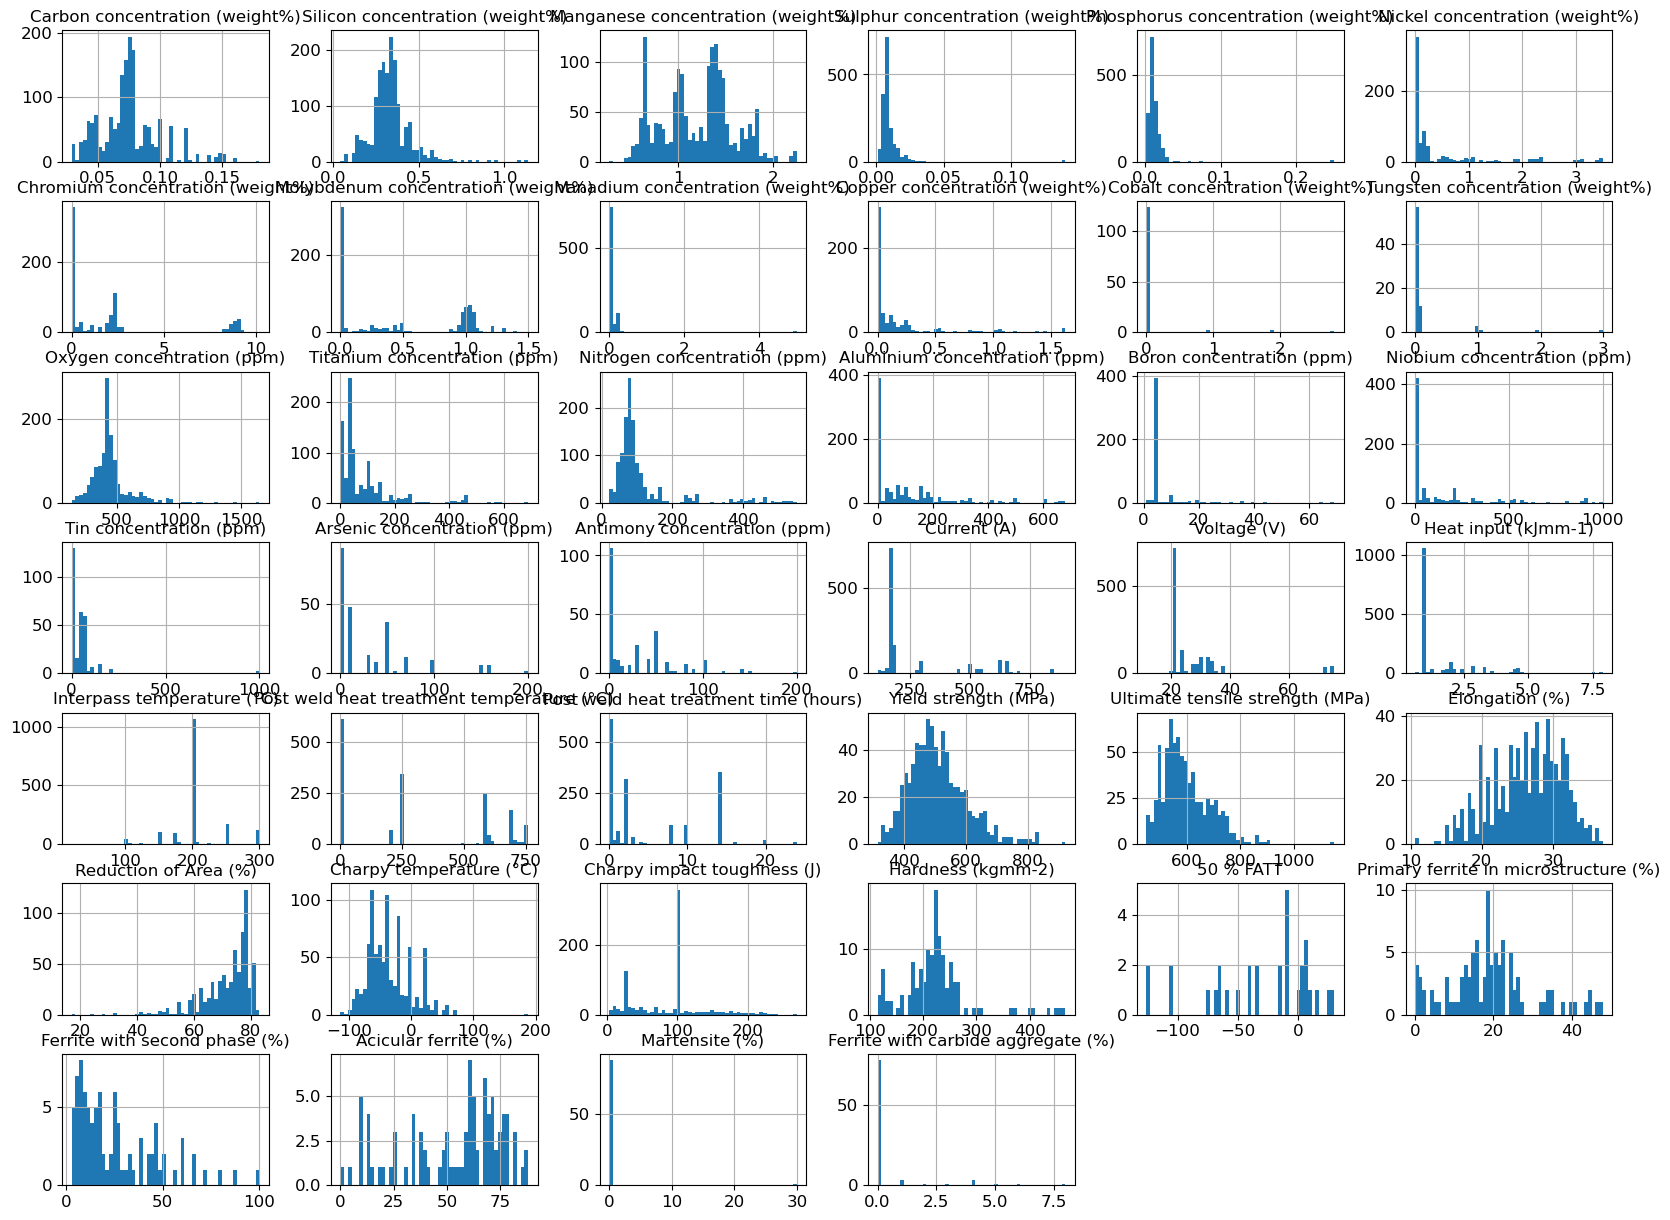

In [20]:
welddb.hist(bins=50, figsize=(20, 15))
plt.show()

# Missing Values

1. **Phosphorus (P) and Sulphur (S) Concentrations**:

   For **Phosphorus (P)** and **Sulphur (S)**, replace the missing values with the **mean values** calculated from the entire dataset (1652 entries).

2. **Other Elements (Mn, Ni, etc.)**:

   For other elements like **Manganese (Mn)**, **Nickel (Ni)**, etc., replace the missing values with **0**, as their absence suggests concentrations close to zero, which is consistent with the idea that they were not deliberately added.

In [21]:
# Replace missing values for Phosphorus (P) and Sulphur (S) with their mean values
welddb['Sulphur concentration (weight%)'].fillna(welddb['Sulphur concentration (weight%)'].mean(), inplace=True)
welddb['Phosphorus concentration (weight%)'].fillna(welddb['Phosphorus concentration (weight%)'].mean(), inplace=True)

# Replace missing values for all other elements with 0 (as they were not deliberately added)
elements_to_zero = [
    'Manganese concentration (weight%)', 'Nickel concentration (weight%)',
    'Chromium concentration (weight%)', 'Molybdenum concentration (weight%)',
    'Vanadium concentration (weight%)', 'Copper concentration (weight%)',
    'Cobalt concentration (weight%)', 'Tungsten concentration (weight%)',
    'Oxygen concentration (ppm)', 'Titanium concentration (ppm)', 
    'Nitrogen concentration (ppm)', 'Aluminium concentration (ppm)', 
    'Boron concentration (ppm)', 'Niobium concentration (ppm)',
    'Tin concentration (ppm)', 'Arsenic concentration (ppm)', 
    'Antimony concentration (ppm)'
]

# Replace missing values with 0 for the other elements
welddb[elements_to_zero] = welddb[elements_to_zero].fillna(0)


C:\Users\12264\AppData\Local\Temp\ipykernel_20820\1098109312.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  welddb['Sulphur concentration (weight%)'].fillna(welddb['Sulphur concentration (weight%)'].mean(), inplace=True)
C:\Users\12264\AppData\Local\Temp\ipykernel_20820\1098109312.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

In [22]:
welddb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Phosphorus concentration (weight%)         1652 non-null   float64
 5   Nickel concentration (weight%)             1652 non-null   float64
 6   Chromium concentration (weight%)           1652 non-null   float64
 7   Molybdenum concentration (weight%)         1652 non-null   float64
 8   Vanadium concentration (weight%)           1652 non-null   float64
 9   Copper concentration (weight%)             1652 non-null   float64
 10  Cobalt concentration (we

# Calculate Power (W)

In [23]:
welddb['Current (A)'].unique()

array([170. , 180. , 165. , 280. , 285. , 680. , 665. , 670. , 640. ,
       660. , 700. ,   nan, 625. , 550. , 850. , 650. , 450. , 181. ,
       201. , 116. , 115. , 163. , 145. , 143. , 146. , 400. , 390. ,
       300. , 275. , 500. , 535. , 290. , 277.5, 150. , 525. , 545. ,
       900. , 190. ])

In [24]:
welddb['Voltage (V)'].unique()

array([21.  , 34.  , 24.  , 25.  , 23.  , 30.  , 32.  ,   nan, 75.36,
       72.24, 28.  , 35.  , 33.  , 38.  , 22.  , 20.  , 31.5 , 11.5 ,
       12.5 , 28.5 , 29.  , 63.  , 26.  , 27.  , 37.5 ])

In [25]:
missing_current = welddb['Current (A)'].isnull()
missing_voltage = welddb['Voltage (V)'].isnull()

# Identify cases where only one of the two features is missing
only_one_missing = (missing_current & ~missing_voltage) | (~missing_current & missing_voltage)

print(welddb[only_one_missing].shape[0])

0


In [26]:
welddb['Power (W)'] = welddb['Current (A)'] * welddb['Voltage (V)']

In [27]:
welddb.shape

(1652, 44)

In [28]:
welddb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Phosphorus concentration (weight%)         1652 non-null   float64
 5   Nickel concentration (weight%)             1652 non-null   float64
 6   Chromium concentration (weight%)           1652 non-null   float64
 7   Molybdenum concentration (weight%)         1652 non-null   float64
 8   Vanadium concentration (weight%)           1652 non-null   float64
 9   Copper concentration (weight%)             1652 non-null   float64
 10  Cobalt concentration (we

# Store the preprocessed database for semi-supervised learning

In [29]:
welddb.to_csv('welddb/welddb_ssl.csv', index=False)